<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/VAE_origin_Exp01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again
* Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum -> mean
* Add 
    * train, test loss plot
    * save model's state dict

* Reference repository: https://github.com/pytorch/examples/tree/master/vae

In [1]:
! nvidia-smi

Wed Jul  1 06:32:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Drive Mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [7]:
# transforms module 사용해서 Image data compose
# ImageFolder를 사용해 dataload

transforms = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 transforms.Grayscale(num_output_channels=1),  # make Image to 1-dim channel
                                 transforms.ToTensor(),                        # convert a PIL Image or numpy ndarray to tensor
                                 # transforms.Normalize()
])

# make custom datasets
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform = transforms)

In [8]:
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
# data_split
# train_dataset, test_dataset

full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [10]:
# make DataLoader

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True)  #pin_memory which enables fast data transfer to CUDA-enabled GPUs

Image 출력하기

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(img, (1, 2, 0)))

    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

In [12]:
# see one element at time

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 3, 24,  6,  3,  2,  3,  2, 24, 23, 12,  2,  3,  2,  2,  2,  3])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.L Yuner.A C2LOP.P Allaple.L Allaple.A Allaple.L Allaple.A Yuner.A Wintrim.BX Lolyda.AA1 Allaple.A Allaple.L Allaple.A Allaple.A Allaple.A Allaple.L 


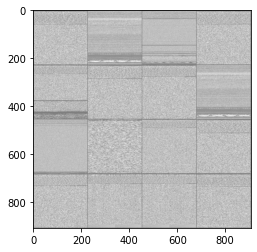

In [13]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [14]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  
                                                
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [15]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html
PATH = './Exp01_10-Epoch.pth'

In [16]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='mean')  # changed reduction to 'mean' 
                                                                                  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    # plt.plot(train_loss / len(train_loader.dataset))
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
    torch.save(model.state_dict(), PATH)


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(16, 1, 224, 224)[:n]])
                save_image(comparison.cpu(),
                         './results_Exp01/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # plt.plot(test_loss)
    Epoch_Loss['test_epoch'].append(epoch)
    Epoch_Loss['test_loss'].append(test_loss)

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 1.090851
Train Epoch: 1 [160/7471 (2%)]	Loss: 4089.269043
Train Epoch: 1 [320/7471 (4%)]	Loss: 2719.924316
Train Epoch: 1 [480/7471 (6%)]	Loss: 2479.512207
Train Epoch: 1 [640/7471 (9%)]	Loss: 2368.345703
Train Epoch: 1 [800/7471 (11%)]	Loss: 2182.987305
Train Epoch: 1 [960/7471 (13%)]	Loss: 1932.893921
Train Epoch: 1 [1120/7471 (15%)]	Loss: 1333.851318
Train Epoch: 1 [1280/7471 (17%)]	Loss: 1203.473022
Train Epoch: 1 [1440/7471 (19%)]	Loss: 1024.647461
Train Epoch: 1 [1600/7471 (21%)]	Loss: 811.860657
Train Epoch: 1 [1760/7471 (24%)]	Loss: 657.017090
Train Epoch: 1 [1920/7471 (26%)]	Loss: 487.855835
Train Epoch: 1 [2080/7471 (28%)]	Loss: 356.955200
Train Epoch: 1 [2240/7471 (30%)]	Loss: 246.646530
Train Epoch: 1 [2400/7471 (32%)]	Loss: 209.177322
Train Epoch: 1 [2560/7471 (34%)]	Loss: 155.723007
Train Epoch: 1 [2720/7471 (36%)]	Loss: 117.597031
Train Epoch: 1 [2880/7471 (39%)]	Loss: 114.348106
Train Epoch: 1 [3040/7471 (41%)]	Loss: 85.554039
Train 

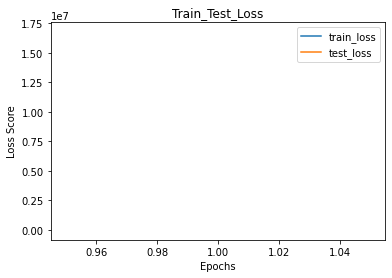

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 1530.484985
Train Epoch: 2 [160/7471 (2%)]	Loss: 1401.231934
Train Epoch: 2 [320/7471 (4%)]	Loss: 1416.697998
Train Epoch: 2 [480/7471 (6%)]	Loss: 1389.169067
Train Epoch: 2 [640/7471 (9%)]	Loss: 1284.729126
Train Epoch: 2 [800/7471 (11%)]	Loss: 1169.051880
Train Epoch: 2 [960/7471 (13%)]	Loss: 1147.601074
Train Epoch: 2 [1120/7471 (15%)]	Loss: 1022.845886
Train Epoch: 2 [1280/7471 (17%)]	Loss: 951.448853
Train Epoch: 2 [1440/7471 (19%)]	Loss: 839.879456
Train Epoch: 2 [1600/7471 (21%)]	Loss: 800.699646
Train Epoch: 2 [1760/7471 (24%)]	Loss: 683.280029
Train Epoch: 2 [1920/7471 (26%)]	Loss: 756.956238
Train Epoch: 2 [2080/7471 (28%)]	Loss: 713.612183
Train Epoch: 2 [2240/7471 (30%)]	Loss: 702.195007
Train Epoch: 2 [2400/7471 (32%)]	Loss: 627.127930
Train Epoch: 2 [2560/7471 (34%)]	Loss: 572.512329
Train Epoch: 2 [2720/7471 (36%)]	Loss: 623.238220
Train Epoch: 2 [2880/7471 (39%)]	Loss: 660.131775
Train Epoch: 2 [3040/7471 (41%)]	Loss: 601.557983
Trai

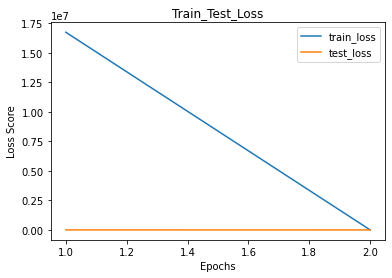

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 34.915535
Train Epoch: 3 [160/7471 (2%)]	Loss: 29.699354
Train Epoch: 3 [320/7471 (4%)]	Loss: 26.416246
Train Epoch: 3 [480/7471 (6%)]	Loss: 30.737804
Train Epoch: 3 [640/7471 (9%)]	Loss: 57.801994
Train Epoch: 3 [800/7471 (11%)]	Loss: 36.268497
Train Epoch: 3 [960/7471 (13%)]	Loss: 63.169399
Train Epoch: 3 [1120/7471 (15%)]	Loss: 203.286453
Train Epoch: 3 [1280/7471 (17%)]	Loss: 233.798218
Train Epoch: 3 [1440/7471 (19%)]	Loss: 256.417969
Train Epoch: 3 [1600/7471 (21%)]	Loss: 260.129547
Train Epoch: 3 [1760/7471 (24%)]	Loss: 256.000000
Train Epoch: 3 [1920/7471 (26%)]	Loss: 233.737061
Train Epoch: 3 [2080/7471 (28%)]	Loss: 300.681366
Train Epoch: 3 [2240/7471 (30%)]	Loss: 229.894073
Train Epoch: 3 [2400/7471 (32%)]	Loss: 242.773193
Train Epoch: 3 [2560/7471 (34%)]	Loss: 221.352539
Train Epoch: 3 [2720/7471 (36%)]	Loss: 220.226166
Train Epoch: 3 [2880/7471 (39%)]	Loss: 195.102173
Train Epoch: 3 [3040/7471 (41%)]	Loss: 180.401627
Train Epoch: 3 [320

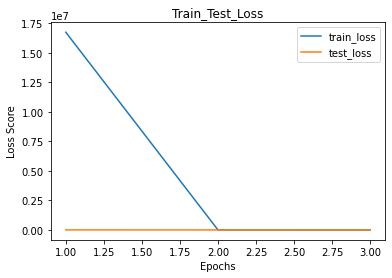

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 398.536865
Train Epoch: 4 [160/7471 (2%)]	Loss: 395.306793
Train Epoch: 4 [320/7471 (4%)]	Loss: 355.976349
Train Epoch: 4 [480/7471 (6%)]	Loss: 346.144287
Train Epoch: 4 [640/7471 (9%)]	Loss: 336.246552
Train Epoch: 4 [800/7471 (11%)]	Loss: 347.341400
Train Epoch: 4 [960/7471 (13%)]	Loss: 307.282898
Train Epoch: 4 [1120/7471 (15%)]	Loss: 269.444824
Train Epoch: 4 [1280/7471 (17%)]	Loss: 231.204697
Train Epoch: 4 [1440/7471 (19%)]	Loss: 228.715469
Train Epoch: 4 [1600/7471 (21%)]	Loss: 379.889984
Train Epoch: 4 [1760/7471 (24%)]	Loss: 238.534729
Train Epoch: 4 [1920/7471 (26%)]	Loss: 784.802307
Train Epoch: 4 [2080/7471 (28%)]	Loss: 2036.282349
Train Epoch: 4 [2240/7471 (30%)]	Loss: 4314.427246
Train Epoch: 4 [2400/7471 (32%)]	Loss: 5863.286621
Train Epoch: 4 [2560/7471 (34%)]	Loss: 6939.158691
Train Epoch: 4 [2720/7471 (36%)]	Loss: 7397.991211
Train Epoch: 4 [2880/7471 (39%)]	Loss: 7821.700195
Train Epoch: 4 [3040/7471 (41%)]	Loss: 8201.109375
Train

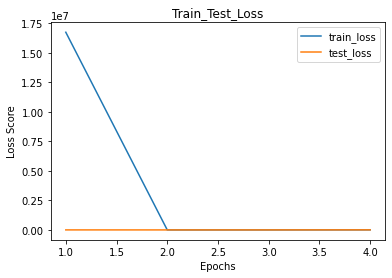

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 5251.862793
Train Epoch: 5 [160/7471 (2%)]	Loss: 5007.617676
Train Epoch: 5 [320/7471 (4%)]	Loss: 4975.237305
Train Epoch: 5 [480/7471 (6%)]	Loss: 5078.178711
Train Epoch: 5 [640/7471 (9%)]	Loss: 4071.422852
Train Epoch: 5 [800/7471 (11%)]	Loss: 4769.377441
Train Epoch: 5 [960/7471 (13%)]	Loss: 4833.848145
Train Epoch: 5 [1120/7471 (15%)]	Loss: 4759.603516
Train Epoch: 5 [1280/7471 (17%)]	Loss: 4371.188965
Train Epoch: 5 [1440/7471 (19%)]	Loss: 4419.431152
Train Epoch: 5 [1600/7471 (21%)]	Loss: 4436.201660
Train Epoch: 5 [1760/7471 (24%)]	Loss: 4349.365723
Train Epoch: 5 [1920/7471 (26%)]	Loss: 4073.206299
Train Epoch: 5 [2080/7471 (28%)]	Loss: 3951.987305
Train Epoch: 5 [2240/7471 (30%)]	Loss: 4037.291504
Train Epoch: 5 [2400/7471 (32%)]	Loss: 4292.969727
Train Epoch: 5 [2560/7471 (34%)]	Loss: 3816.902832
Train Epoch: 5 [2720/7471 (36%)]	Loss: 3969.384521
Train Epoch: 5 [2880/7471 (39%)]	Loss: 3641.879639
Train Epoch: 5 [3040/7471 (41%)]	Loss: 3825

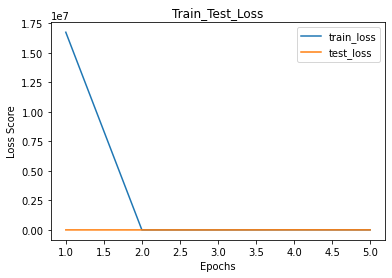

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 2587.424561
Train Epoch: 6 [160/7471 (2%)]	Loss: 2423.413086
Train Epoch: 6 [320/7471 (4%)]	Loss: 2330.227539
Train Epoch: 6 [480/7471 (6%)]	Loss: 2348.088623
Train Epoch: 6 [640/7471 (9%)]	Loss: 2178.539551
Train Epoch: 6 [800/7471 (11%)]	Loss: 2217.561279
Train Epoch: 6 [960/7471 (13%)]	Loss: 2171.323975
Train Epoch: 6 [1120/7471 (15%)]	Loss: 2171.881348
Train Epoch: 6 [1280/7471 (17%)]	Loss: 2260.380859
Train Epoch: 6 [1440/7471 (19%)]	Loss: 2432.514404
Train Epoch: 6 [1600/7471 (21%)]	Loss: 2021.588501
Train Epoch: 6 [1760/7471 (24%)]	Loss: 2256.431885
Train Epoch: 6 [1920/7471 (26%)]	Loss: 2016.054077
Train Epoch: 6 [2080/7471 (28%)]	Loss: 2022.688965
Train Epoch: 6 [2240/7471 (30%)]	Loss: 2087.236328
Train Epoch: 6 [2400/7471 (32%)]	Loss: 2102.009766
Train Epoch: 6 [2560/7471 (34%)]	Loss: 2076.772461
Train Epoch: 6 [2720/7471 (36%)]	Loss: 2151.968262
Train Epoch: 6 [2880/7471 (39%)]	Loss: 1958.876831
Train Epoch: 6 [3040/7471 (41%)]	Loss: 2008

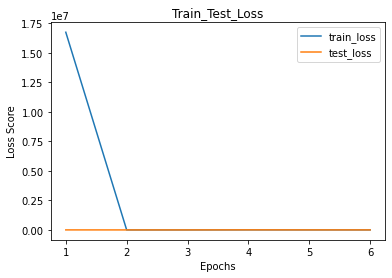

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 1589.353882
Train Epoch: 7 [160/7471 (2%)]	Loss: 1547.878662
Train Epoch: 7 [320/7471 (4%)]	Loss: 1577.277222
Train Epoch: 7 [480/7471 (6%)]	Loss: 1586.186768
Train Epoch: 7 [640/7471 (9%)]	Loss: 1594.916016
Train Epoch: 7 [800/7471 (11%)]	Loss: 1561.108398
Train Epoch: 7 [960/7471 (13%)]	Loss: 1543.512939
Train Epoch: 7 [1120/7471 (15%)]	Loss: 1771.283936
Train Epoch: 7 [1280/7471 (17%)]	Loss: 1673.016846
Train Epoch: 7 [1440/7471 (19%)]	Loss: 1681.314941
Train Epoch: 7 [1600/7471 (21%)]	Loss: 1671.255127
Train Epoch: 7 [1760/7471 (24%)]	Loss: 9646.765625
Train Epoch: 7 [1920/7471 (26%)]	Loss: 5020.151367
Train Epoch: 7 [2080/7471 (28%)]	Loss: 6096.413086
Train Epoch: 7 [2240/7471 (30%)]	Loss: 6892.345215
Train Epoch: 7 [2400/7471 (32%)]	Loss: 6589.444824
Train Epoch: 7 [2560/7471 (34%)]	Loss: 7061.857422
Train Epoch: 7 [2720/7471 (36%)]	Loss: 7643.032227
Train Epoch: 7 [2880/7471 (39%)]	Loss: 7545.186523
Train Epoch: 7 [3040/7471 (41%)]	Loss: 7509

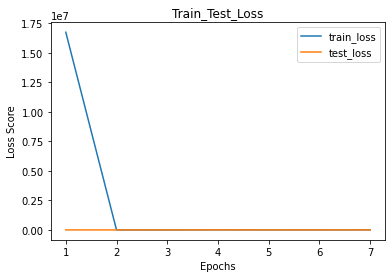

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 4177.467285
Train Epoch: 8 [160/7471 (2%)]	Loss: 4375.469238
Train Epoch: 8 [320/7471 (4%)]	Loss: 3794.166504
Train Epoch: 8 [480/7471 (6%)]	Loss: 3979.896973
Train Epoch: 8 [640/7471 (9%)]	Loss: 4037.327393
Train Epoch: 8 [800/7471 (11%)]	Loss: 3835.824219
Train Epoch: 8 [960/7471 (13%)]	Loss: 3880.266846
Train Epoch: 8 [1120/7471 (15%)]	Loss: 3684.327881
Train Epoch: 8 [1280/7471 (17%)]	Loss: 3314.884033
Train Epoch: 8 [1440/7471 (19%)]	Loss: 3665.788330
Train Epoch: 8 [1600/7471 (21%)]	Loss: 3421.287109
Train Epoch: 8 [1760/7471 (24%)]	Loss: 3343.898682
Train Epoch: 8 [1920/7471 (26%)]	Loss: 3331.190186
Train Epoch: 8 [2080/7471 (28%)]	Loss: 3566.684326
Train Epoch: 8 [2240/7471 (30%)]	Loss: 3400.461670
Train Epoch: 8 [2400/7471 (32%)]	Loss: 3337.083740
Train Epoch: 8 [2560/7471 (34%)]	Loss: 3291.821777
Train Epoch: 8 [2720/7471 (36%)]	Loss: 3329.757324
Train Epoch: 8 [2880/7471 (39%)]	Loss: 3243.264404
Train Epoch: 8 [3040/7471 (41%)]	Loss: 3183

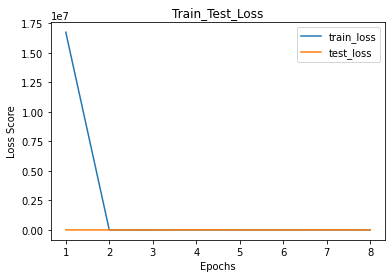

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 2335.286133
Train Epoch: 9 [160/7471 (2%)]	Loss: 2233.471191
Train Epoch: 9 [320/7471 (4%)]	Loss: 2154.510986
Train Epoch: 9 [480/7471 (6%)]	Loss: 2150.320312
Train Epoch: 9 [640/7471 (9%)]	Loss: 2238.725830
Train Epoch: 9 [800/7471 (11%)]	Loss: 2047.625244
Train Epoch: 9 [960/7471 (13%)]	Loss: 2077.545654
Train Epoch: 9 [1120/7471 (15%)]	Loss: 1910.433716
Train Epoch: 9 [1280/7471 (17%)]	Loss: 2068.888672
Train Epoch: 9 [1440/7471 (19%)]	Loss: 2063.430908
Train Epoch: 9 [1600/7471 (21%)]	Loss: 1961.531494
Train Epoch: 9 [1760/7471 (24%)]	Loss: 2067.372803
Train Epoch: 9 [1920/7471 (26%)]	Loss: 1852.926147
Train Epoch: 9 [2080/7471 (28%)]	Loss: 1941.273682
Train Epoch: 9 [2240/7471 (30%)]	Loss: 1790.583130
Train Epoch: 9 [2400/7471 (32%)]	Loss: 1737.929688
Train Epoch: 9 [2560/7471 (34%)]	Loss: 1743.062988
Train Epoch: 9 [2720/7471 (36%)]	Loss: 1751.278076
Train Epoch: 9 [2880/7471 (39%)]	Loss: 1793.353638
Train Epoch: 9 [3040/7471 (41%)]	Loss: 1786

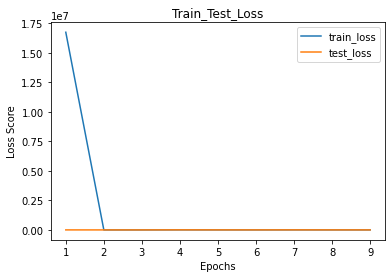

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 1325.635742
Train Epoch: 10 [160/7471 (2%)]	Loss: 1242.660034
Train Epoch: 10 [320/7471 (4%)]	Loss: 1223.414673
Train Epoch: 10 [480/7471 (6%)]	Loss: 1211.543091
Train Epoch: 10 [640/7471 (9%)]	Loss: 1286.819092
Train Epoch: 10 [800/7471 (11%)]	Loss: 1226.917969
Train Epoch: 10 [960/7471 (13%)]	Loss: 1159.295776
Train Epoch: 10 [1120/7471 (15%)]	Loss: 1093.614868
Train Epoch: 10 [1280/7471 (17%)]	Loss: 1152.365723
Train Epoch: 10 [1440/7471 (19%)]	Loss: 1238.265015
Train Epoch: 10 [1600/7471 (21%)]	Loss: 1418.312988
Train Epoch: 10 [1760/7471 (24%)]	Loss: 1511.563599
Train Epoch: 10 [1920/7471 (26%)]	Loss: 1352.981323
Train Epoch: 10 [2080/7471 (28%)]	Loss: 1217.899658
Train Epoch: 10 [2240/7471 (30%)]	Loss: 1231.476440
Train Epoch: 10 [2400/7471 (32%)]	Loss: 1409.315674
Train Epoch: 10 [2560/7471 (34%)]	Loss: 1575.338257
Train Epoch: 10 [2720/7471 (36%)]	Loss: 1497.356201
Train Epoch: 10 [2880/7471 (39%)]	Loss: 1556.971436
Train Epoch: 10 [3040/7

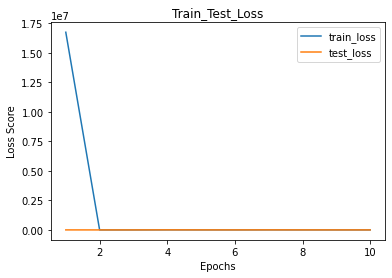

In [17]:
epochs = 10


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp01/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp01/sample_' + str(epoch) + '.png')
        

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [19]:
epochs = 120


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp01/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp01/sample_' + str(epoch) + '.png')
        

1


RuntimeError: ignored